# Identify generic genes and pathways

Studies have found that some genes are more likely to be differentially expressed even across a wide range of experimental designs. These generic genes and subsequent pathways are not necessarily specific to the biological process being studied but instead represent a more systematic change.

This notebook identifies generic genes and pathways and then evaluates if those identified are consistent with published findings.

**Steps to identify generic genes:**
1. Simulates N gene expression experiments using [ponyo](https://github.com/ajlee21/ponyo)
2. Perform DE analysis to get association statistics for each gene

  In this case the DE analysis is based on the experimental design of the template experiment, described in the previous [notebook](1_process_recount2_data.ipynb). The template experiment is [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764), which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients. So the DE analysis is comparing tumor vs normal in this case.


3. For each gene, aggregate statsitics across all simulated experiments
4. Rank genes based on this aggregated statistic (i.e. log fold change, or p-value)


**Steps to identify generic gene sets (pathways):**
1. Using the same simulated experiments from above, perform GSEA analysis. This analysis will determine whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list of genes, where genes are ranked by log fold change, indicating a correlation with change in expression.
2. For each gene set (pathway), aggregate statistics across all simulated experiments
3. Rank gene sets based on this aggregated statistic

**Evaluation:**
* We want to compare the ranking of genes identified using the above method with the ranking found from [Crow et. al.](https://www.pnas.org/content/pnas/116/13/6491.full.pdf), which identified a set of genes as generic based on how frequently they were found to be DE across 600 experiments
* We want to compare the ranking of pathways identified using the above method with the ranking based on the [Powers et. al.](https://www.biorxiv.org/content/10.1101/259440v1.full.pdf) data, where ranking was determined based on the fraction of 442 experiments a pathway was found to be enriched
* This comparison will validate our method being used as a way to automatically identify generic genes and pathways.

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import pickle
import scipy.stats as ss
import glob
import warnings
from keras.models import load_model
from sklearn import preprocessing

from rpy2.robjects import pandas2ri
from ponyo import utils
from generic_expression_patterns_modules import process, stats, ranking

pandas2ri.activate()

np.random.seed(123)

Using TensorFlow backend.
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_general_MRnorm.tsv")
)

params = utils.read_config(config_filename)

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params["dataset_name"]
NN_architecture = params["NN_architecture"]
num_runs = params["num_simulated"]
project_id = params["project_id"]
metadata_col_id = params["metadata_colname"]
mapped_template_filename = params["mapped_template_filename"]
processed_template_filename = params["processed_template_filename"]
normalized_compendium_filename = params["normalized_compendium_filename"]
scaler_filename = params["scaler_filename"]
col_to_rank_genes = params["rank_genes_by"]
col_to_rank_pathways = params["rank_pathways_by"]
statistic = params["gsea_statistic"]
count_threshold = params["count_threshold"]
logFC_name = params["DE_logFC_name"]
pvalue_name = params["DE_pvalue_name"]
latent_dim = params["latent_dim"]


# Load metadata file with grouping assignments for samples
sample_id_metadata_filename = os.path.join(
    base_dir, dataset_name, "data", "metadata", f"{project_id}_process_samples.tsv"
)

# Load metadata file with grouping assignments for samples
metadata_filename = os.path.join(
    base_dir, dataset_name, "data", "metadata", f"{project_id}_groups.tsv"
)

# Load pickled file
with open(scaler_filename, "rb") as scaler_fh:
    scaler = pickle.load(scaler_fh)

# Percentile threshold to identify generic genes
percentile_threshold = 80.0

In [5]:
# Output files
gene_summary_filename = os.path.join(
    base_dir, dataset_name, f"generic_gene_summary_{project_id}_MRnorm.tsv"
)

pathway_summary_filename = os.path.join(
    base_dir, dataset_name, f"generic_pathway_summary_{project_id}_MRnorm.tsv"
)

In [6]:
# Functions from ponyo 0.2 that I temporarily imported due to hard coded issue
def get_sample_ids(experiment_id, dataset_name, sample_id_colname):
    """
    Returns sample ids (found in gene expression df) associated with
    a given list of experiment ids (found in the metadata)

    Arguments
    ----------
    experiment_ids_file: str
        File containing all cleaned experiment ids

    dataset_name: str
        Name for analysis directory. Either "Human" or "Pseudomonas"

    sample_id_colname: str
        Column header that contains sample id that maps expression data
        and metadata

    """
    base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

    # metadata file
    mapping_file = os.path.join(
        base_dir, dataset_name, "data", "metadata", "recount2_metadata.tsv"
    )

    # Read in metadata
    metadata = pd.read_csv(mapping_file, header=0, sep="\t", index_col=0)

    selected_metadata = metadata.loc[experiment_id]
    sample_ids = list(selected_metadata[sample_id_colname])

    return sample_ids


def shift_template_experiment_tmp(
    normalized_data_file,
    selected_experiment_id,
    sample_id_colname,
    NN_architecture,
    latent_dim,
    dataset_name,
    scaler,
    local_dir,
    base_dir,
    run,
):
    """
    Generate new simulated experiment using the selected_experiment_id as a template
    experiment using the same workflow as `simulate_by_latent_transform`

    This will return a file with a single simulated experiment following the workflow mentioned.
    This function can be run multiple times to generate multiple simulated experiments from a
    single selected_experiment_id.

    Arguments
    ----------
    normalized_data_file: str
        File containing normalized gene expression data

        ------------------------------| PA0001 | PA0002 |...
        05_PA14000-4-2_5-10-07_S2.CEL | 0.8533 | 0.7252 |...
        54375-4-05.CEL                | 0.7789 | 0.7678 |...
        ...                           | ...    | ...    |...

    selected_experiment_id: str
        Experiment id selected as template

    sample_id_colname: str
        Column header that contains sample id that maps expression data and metadata

    NN_architecture: str
        Name of neural network architecture to use.
        Format 'NN_<intermediate layer>_<latent layer>'

    dataset_name: str
        Name for analysis directory. Either "Human" or "Pseudomonas"

    scaler: minmax model
        Model used to transform data into a different range

    local_dir: str
        Parent directory on local machine to store intermediate results

    base_dir: str
        Root directory containing analysis subdirectories

    run: int
        Simulation run

    Returns
    --------
    simulated_data_file: str
        File containing simulated gene expression data

    """

    # Files
    NN_dir = os.path.join(base_dir, dataset_name, "models", NN_architecture)

    model_encoder_file = glob.glob(os.path.join(NN_dir, "*_encoder_model.h5"))[0]

    weights_encoder_file = glob.glob(os.path.join(NN_dir, "*_encoder_weights.h5"))[0]

    model_decoder_file = glob.glob(os.path.join(NN_dir, "*_decoder_model.h5"))[0]

    weights_decoder_file = glob.glob(os.path.join(NN_dir, "*_decoder_weights.h5"))[0]

    # Load saved models
    loaded_model = load_model(model_encoder_file, compile=False)
    loaded_decode_model = load_model(model_decoder_file, compile=False)

    loaded_model.load_weights(weights_encoder_file)
    loaded_decode_model.load_weights(weights_decoder_file)

    # Read data
    normalized_data = pd.read_csv(normalized_data_file, header=0, sep="\t", index_col=0)

    # Get corresponding sample ids
    sample_ids = get_sample_ids(selected_experiment_id, dataset_name, sample_id_colname)

    # Gene expression data for selected samples
    selected_data_df = normalized_data.loc[sample_ids]

    # Encode selected experiment into latent space
    data_encoded = loaded_model.predict_on_batch(selected_data_df)
    data_encoded_df = pd.DataFrame(data_encoded, index=selected_data_df.index)

    # Get centroid of original data
    centroid = data_encoded_df.mean(axis=0)

    # Add individual vectors(centroid, sample point) to new_centroid

    # Encode original gene expression data into latent space
    data_encoded_all = loaded_model.predict_on_batch(normalized_data)
    data_encoded_all_df = pd.DataFrame(data_encoded_all, index=normalized_data.index)

    data_encoded_all_df.head()

    # Find a new location in the latent space by sampling from the latent space
    encoded_means = data_encoded_all_df.mean(axis=0)
    encoded_stds = data_encoded_all_df.std(axis=0)

    latent_dim = int(latent_dim)
    new_centroid = np.zeros(latent_dim)

    for j in range(latent_dim):
        new_centroid[j] = np.random.normal(encoded_means[j], encoded_stds[j])

    shift_vec_df = new_centroid - centroid
    # print(shift_vec_df)

    simulated_data_encoded_df = data_encoded_df.apply(
        lambda x: x + shift_vec_df, axis=1
    )

    # Decode simulated data into raw gene space
    simulated_data_decoded = loaded_decode_model.predict_on_batch(
        simulated_data_encoded_df
    )

    simulated_data_decoded_df = pd.DataFrame(
        simulated_data_decoded,
        index=simulated_data_encoded_df.index,
        columns=selected_data_df.columns,
    )

    # Un-normalize the data in order to run DE analysis downstream
    simulated_data_scaled = scaler.inverse_transform(simulated_data_decoded_df)

    simulated_data_scaled_df = pd.DataFrame(
        simulated_data_scaled,
        columns=simulated_data_decoded_df.columns,
        index=simulated_data_decoded_df.index,
    )

    # Save template data for visualization validation
    test_file = os.path.join(
        local_dir,
        "pseudo_experiment",
        "template_normalized_data_" + selected_experiment_id + "_test.txt",
    )

    selected_data_df.to_csv(test_file, float_format="%.3f", sep="\t")

    # Save
    out_file = os.path.join(
        local_dir,
        "pseudo_experiment",
        "selected_simulated_data_" + selected_experiment_id + "_" + str(run) + ".txt",
    )

    simulated_data_scaled_df.to_csv(out_file, float_format="%.3f", sep="\t")

    out_encoded_file = os.path.join(
        local_dir,
        "pseudo_experiment",
        f"selected_simulated_encoded_data_{selected_experiment_id}_{run}.txt",
    )

    simulated_data_encoded_df.to_csv(out_encoded_file, float_format="%.3f", sep="\t")

### Simulate experiments using selected template experiment

Workflow:

1. Get the gene expression data for the selected template experiment
2. Encode this experiment into a latent space using the trained VAE model
3. Linearly shift the encoded template experiment in the latent space
4. Decode the samples. This results in a new experiment
5. Repeat steps 1-4 to get multiple simulated experiments

In [7]:
# Simulate multiple experiments
# This step creates the following files in "<local_dir>/pseudo_experiment/" directory:
#   - selected_simulated_data_SRP012656_<n>.txt
#   - selected_simulated_encoded_data_SRP012656_<n>.txt
#   - template_normalized_data_SRP012656_test.txt
# in which "<n>" is an integer in the range of [0, num_runs-1]
os.makedirs(os.path.join(local_dir, "pseudo_experiment"), exist_ok=True)
for run_id in range(num_runs):
    shift_template_experiment_tmp(
        normalized_compendium_filename,
        project_id,
        metadata_col_id,
        NN_architecture,
        latent_dim,
        dataset_name,
        scaler,
        local_dir,
        base_dir,
        run_id,
    )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



## Reverse MR normalization
Tutorial on MR normalization is [here](https://hbctraining.github.io/DGE_workshop/lessons/02_DGE_count_normalization.html)

Normalized count = raw count/scale factor

In [8]:
sf_filename = "data/metadata/MR_norm_compendium_size_factor.tsv"
size_factor = pd.read_csv(sf_filename, sep="\t")

In [9]:
size_factor.head()

,x
DRR000897,2.819011
DRR001173,3.423065
DRR001174,3.489644
DRR001175,3.007419
DRR001176,2.845268


In [10]:
for i in range(num_runs):
    simulated_filename = os.path.join(
        local_dir, "pseudo_experiment", f"selected_simulated_data_{project_id}_{i}.txt"
    )
    MRnorm_simulated_data = pd.read_csv(
        simulated_filename, sep="\t", index_col=0, header=0
    )

    size_factor_subset = size_factor.loc[MRnorm_simulated_data.index]

    raw_simulated_data = np.multiply(MRnorm_simulated_data, size_factor_subset)

    raw_simulated_data.to_csv(simulated_filename, sep="\t")

### Process template and simulated experiments

* Remove samples not required for comparison
* Make sure ordering of samples matches metadata for proper comparison
* Make sure values are cast as integers for using DESeq
* Filter lowly expressed genes for using DESeq

In [11]:
if not os.path.exists(sample_id_metadata_filename):
    sample_id_metadata_filename = None

stats.process_samples_for_DESeq(
    mapped_template_filename,
    metadata_filename,
    processed_template_filename,
    count_threshold,
    sample_id_metadata_filename,
)

for i in range(num_runs):
    simulated_filename = os.path.join(
        local_dir, "pseudo_experiment", f"selected_simulated_data_{project_id}_{i}.txt"
    )
    out_simulated_filename = os.path.join(
        local_dir,
        "pseudo_experiment",
        f"selected_simulated_data_{project_id}_{i}_processed.txt",
    )
    stats.process_samples_for_DESeq(
        simulated_filename,
        metadata_filename,
        out_simulated_filename,
        count_threshold,
        sample_id_metadata_filename,
    )

sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly


### Differential expression analysis

The gene expression dataset is using RNA-seq so we will use DESeq2 in this case

In [12]:
# Create subdirectory: "<local_dir>/DE_stats/"
os.makedirs(os.path.join(local_dir, "DE_stats"), exist_ok=True)

In [13]:
%%R -i metadata_filename -i project_id -i processed_template_filename -i local_dir -i base_dir

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# File created: "<local_dir>/DE_stats/DE_stats_template_data_<project_id>_real.txt"
get_DE_stats_DESeq(metadata_filename,
                   project_id,
                   processed_template_filename,
                   "template",
                   local_dir,
                   "real")

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following object is masked from ‘package:limma’:

    plotMA


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply

[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 128 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



In [14]:
# Check number of DEGs
template_DE_stats_filename = os.path.join(
    local_dir, "DE_stats", f"DE_stats_template_data_{project_id}_real.txt"
)

template_DE_stats = pd.read_csv(
    template_DE_stats_filename, sep="\t", header=0, index_col=0
)

selected = template_DE_stats[
    (template_DE_stats["padj"] < 0.01) & (abs(template_DE_stats["log2FoldChange"]) > 1)
]
print(selected.shape)

(3277, 6)


In [15]:
%%R -i metadata_filename -i project_id -i base_dir -i local_dir -i num_runs

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# Files created: "<local_dir>/DE_stats/DE_stats_simulated_data_SRP012656_<n>.txt"
for (i in 0:(num_runs-1)){
    simulated_data_filename <- paste(local_dir,
                                     "pseudo_experiment/selected_simulated_data_",
                                     project_id,
                                     "_",
                                     i,
                                     "_processed.txt",
                                     sep = "")

    get_DE_stats_DESeq(metadata_filename,
                       project_id,
                       simulated_data_filename,
                       "simulated",
                       local_dir,
                       i)
}

[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 2 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 8 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 2 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 2 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 2 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 3 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 2 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 2 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



**Validation:**
* As a quick validation, [Kim et. al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3566005/) found 1459 DEGs (543 upregulated and 916 downregulated) using used the Bowtie and NEUMA applications for the mapping and quantification of RNA-Seq data. They used *edgeR* with a rigorous filtering procedure based on false discovery rates, minimum applicable patient numbers, and gene expression levels was devised to select reliable sets of DEGs and DEIs (see File S8 for details). For the

* Our results found ~3K DEGs which is close enough in range given that the data was processed using different methods. recount2 resource were aligned with the splice-aware Rail-RNA aligner

### Rank genes

In [16]:
analysis_type = "DE"
template_DE_stats, simulated_DE_summary_stats = ranking.process_and_rank_genes_pathways(
    template_DE_stats_filename,
    local_dir,
    num_runs,
    project_id,
    analysis_type,
    col_to_rank_genes,
    logFC_name,
    pvalue_name,
)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


### Gene summary table

Note: Using DESeq, genes with NaN in `Adj P-value (Real)` column are those genes flagged because of the `cooksCutoff` parameter. The cook's distance as a diagnostic to tell if a single sample has a count which has a disproportionate impact on the log fold change and p-values. These genes are flagged with an NA in the pvalue and padj columns of the result table. For more information you can read [DESeq FAQs](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#pvaluesNA)

In [17]:
summary_gene_ranks = ranking.generate_summary_table(
    template_DE_stats_filename,
    template_DE_stats,
    simulated_DE_summary_stats,
    col_to_rank_genes,
    local_dir,
    "gene",
    params,
)

summary_gene_ranks.head()

,Gene ID,Adj P-value (Real),Rank (Real),abs(log2FoldChange) (Real),log2FoldChange (Real),Median adj p-value (simulated),Rank (simulated),Percentile (simulated),Percent DE (simulated),Mean abs(log2FoldChange) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
PAX7,PAX7,5.950002e-13,17569.0,10.694069,10.694069,4.810025e-02,8799.0,49.555030,0.00,0.154023,0.050692,25,207.924344
PRAME,PRAME,2.959850e-15,17568.0,8.664896,8.664896,8.449033e-01,3532.0,19.888476,0.00,0.068596,0.042136,25,204.012794
SLCO1B3,SLCO1B3,5.291828e-04,17567.0,8.325529,8.325529,9.641310e-04,11668.0,65.714769,0.00,0.259197,0.078915,25,102.215388
KCNC2,KCNC2,1.983864e-10,17566.0,8.230783,8.230783,5.920781e-01,6125.0,34.493635,0.00,0.109919,0.037300,25,217.716226
HOTAIR,HOTAIR,3.115155e-10,17565.0,8.228355,8.228355,7.228657e-08,17541.0,98.794638,0.72,1.042428,0.132555,25,54.211076


In [18]:
summary_gene_ranks.isna().any()

Gene ID                                 False
Adj P-value (Real)                       True
Rank (Real)                              True
abs(log2FoldChange) (Real)               True
log2FoldChange (Real)                    True
Median adj p-value (simulated)          False
Rank (simulated)                        False
Percentile (simulated)                  False
Percent DE (simulated)                  False
Mean abs(log2FoldChange) (simulated)    False
Std deviation (simulated)               False
Number of experiments (simulated)       False
Z score                                  True
dtype: bool

In [19]:
# Create `gene_summary_filename`
summary_gene_ranks.to_csv(gene_summary_filename, sep="\t")

### Compare gene ranking
Studies have found that some genes are more likely to be differentially expressed even across a wide range of experimental designs. These *generic genes* are not necessarily specific to the biological process being studied but instead represent a more systematic change.

We want to compare the ability to detect these generic genes using our method vs those found by [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf). Their genes are ranked 0 = not commonly DE; 1 = commonly DE. Genes by the number differentially expressed gene sets they appear in and then ranking genes by this score.

r = 0.08911653521707949
p = 1.3520534244934854e-31
ci_low = 0.07482900199878373
ci_high = 0.10484947208388169


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


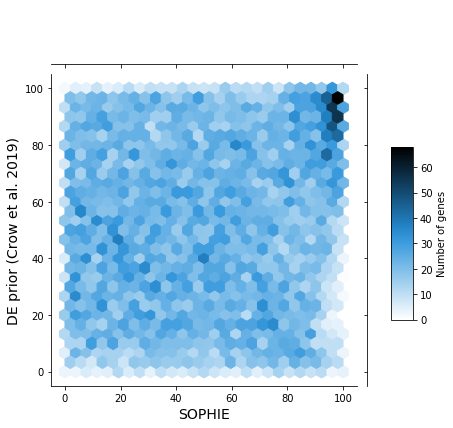

In [20]:
# Get generic genes identified by Crow et. al.
DE_prior_filename = params["reference_gene_filename"]
ref_gene_col = params["reference_gene_name_col"]
ref_rank_col = params["reference_rank_col"]

figure_filename = f"gene_ranking_{col_to_rank_genes}_MRnorm.svg"

corr, shared_ranking = ranking.compare_gene_ranking(
    summary_gene_ranks, DE_prior_filename, ref_gene_col, ref_rank_col, figure_filename
)

Hypergeometric test:

Given N number of genes with K common genes in Crow et al. SOPHIE identifies n genes as being common. What is the probability that k of the genes identified by SOPHIE are also common in Crow et al.? What is the probability of drawing k or more concordant genes?

This was a way for us to quantify the correlation between SOPHIE and Crow et al common findings, since the correlation coefficient wasn't very convincing since we're considering all genes in addition to the common ones

In [21]:
num_Crow_genes = shared_ranking.shape[0]
num_generic_Crow_genes = shared_ranking.query(f"{ref_rank_col}>=80.0").shape[0]
num_generic_SOPHIE_genes = shared_ranking[
    shared_ranking["Percentile (simulated)"] >= percentile_threshold
].shape[0]
num_concordant_generic_genes = shared_ranking[
    (shared_ranking[ref_rank_col] >= percentile_threshold)
    & (shared_ranking["Percentile (simulated)"] >= percentile_threshold)
].shape[0]

In [22]:
print(num_Crow_genes)
print(num_generic_Crow_genes)
print(num_generic_SOPHIE_genes)
print(num_concordant_generic_genes)

17156
3678
3430
1098


In [23]:
p = ss.hypergeom.sf(
    num_concordant_generic_genes,
    num_Crow_genes,
    num_generic_Crow_genes,
    num_generic_SOPHIE_genes,
)
print(p)

4.8217508578631057e-60


**Takeaway:**
Based on the correlation plot, we can see that our simulation method is very good at capturing variability in genes that are very low or very high in the DE rank (i.e. are significantly differentially expressed often across different studies). These results serve to validate that our method can be used to identify these generic genes, as we were able to recapitulate some of the generic genes as those identified by Crow et. al. Additionally, our method extends the Crow et. al. work, which used array data, and since here we used RNA-seq.

### GSEA
**Goal:** To detect modest but coordinated changes in prespecified sets of related genes (i.e. those genes in the same pathway or share the same GO term).

1. Rank all genes using DE association statistics.
2. An enrichment score (ES) is defined as the maximum distance from the middle of the ranked list. Thus, the enrichment score indicates whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list (indicating a correlation with change in expression).
3. Estimate the statistical significance of the ES by a phenotypic-based permutation test in order to produce a null distribution for the ES (i.e. scores based on permuted phenotype)

In [24]:
# Create "<local_dir>/GSEA_stats/" subdirectory
os.makedirs(os.path.join(local_dir, "GSA_stats"), exist_ok=True)

In [25]:
# Load pathway data
hallmark_DB_filename = params["pathway_DB_filename"]

In [26]:
%%R -i base_dir -i template_DE_stats_filename -i hallmark_DB_filename -i statistic -o template_enriched_pathways

source(paste0(base_dir, '/generic_expression_patterns_modules/GSEA_analysis.R'))

out_filename <- paste(local_dir,
                     "GSA_stats/GSEA_stats_template_data_",
                     project_id,
                     "_real.txt",
                     sep = "")

template_enriched_pathways <- find_enriched_pathways(template_DE_stats_filename, hallmark_DB_filename, statistic)

template_enriched_pathways <- as.data.frame(template_enriched_pathways[1:7])

write.table(template_enriched_pathways, file = out_filename, row.names = F, sep = "\t")

R[write to console]: Loading required package: Rcpp



In [27]:
print(template_enriched_pathways.shape)
template_enriched_pathways[template_enriched_pathways["padj"] < 0.05].sort_values(
    by="padj"
)

(50, 7)


,pathway,pval,padj,ES,NES,nMoreExtreme,size
13,HALLMARK_E2F_TARGETS,0.000123,0.002057,0.545914,1.930252,0.0,185
18,HALLMARK_G2M_CHECKPOINT,0.000123,0.002057,0.544701,1.925286,0.0,184
19,HALLMARK_GLYCOLYSIS,0.000122,0.002057,0.519166,1.846378,0.0,196
2,HALLMARK_ALLOGRAFT_REJECTION,0.000516,0.002112,-0.393556,-1.608738,0.0,180
45,HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.000549,0.002112,-0.672292,-2.776146,0.0,197
44,HALLMARK_TGF_BETA_SIGNALING,0.000314,0.002112,-0.592356,-2.013852,0.0,54
34,HALLMARK_MYOGENESIS,0.000545,0.002112,-0.438242,-1.808167,0.0,195
27,HALLMARK_INTERFERON_GAMMA_RESPONSE,0.000530,0.002112,-0.379436,-1.553304,0.0,185
25,HALLMARK_INFLAMMATORY_RESPONSE,0.000549,0.002112,-0.522549,-2.157803,0.0,197
23,HALLMARK_IL2_STAT5_SIGNALING,0.000546,0.002112,-0.433876,-1.785863,0.0,193


In [28]:
%%R -i project_id -i local_dir -i hallmark_DB_filename -i num_runs -i statistic -i base_dir

source(paste0(base_dir, '/generic_expression_patterns_modules/GSEA_analysis.R'))

# New files created: "<local_dir>/GSEA_stats/GSEA_stats_simulated_data_<project_id>_<n>.txt"
for (i in 0:(num_runs-1)) {
    simulated_DE_stats_filename <- paste(local_dir,
                                     "DE_stats/DE_stats_simulated_data_",
                                     project_id,
                                     "_",
                                     i,
                                     ".txt",
                                     sep = "")

    out_filename <- paste(local_dir,
                     "GSA_stats/GSEA_stats_simulated_data_",
                     project_id,
                     "_",
                     i,
                     ".txt",
                     sep = "")

    enriched_pathways <- find_enriched_pathways(simulated_DE_stats_filename, hallmark_DB_filename, statistic)

    write.table(as.data.frame(enriched_pathways[1:7]), file = out_filename, row.names = F, sep = "\t")
}

### Rank pathways

In [29]:
analysis_type = "GSA"
template_GSEA_stats_filename = os.path.join(
    local_dir, "GSA_stats", f"GSEA_stats_template_data_{project_id}_real.txt"
)
(
    template_GSEA_stats,
    simulated_GSEA_summary_stats,
) = ranking.process_and_rank_genes_pathways(
    template_GSEA_stats_filename,
    local_dir,
    num_runs,
    project_id,
    analysis_type,
    col_to_rank_pathways,
    logFC_name,
    pvalue_name,
    "GSEA",
)

### Pathway summary table

In [30]:
# Create intermediate file: "<local_dir>/gene_summary_table_<col_to_rank_pathways>.tsv"
summary_pathway_ranks = ranking.generate_summary_table(
    template_GSEA_stats_filename,
    template_GSEA_stats,
    simulated_GSEA_summary_stats,
    col_to_rank_pathways,
    local_dir,
    "pathway",
    params,
)

summary_pathway_ranks.head()

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Pathway ID,Adj P-value (Real),Rank (Real),padj (Real),Median adj p-value (simulated),Rank (simulated),Percentile (simulated),Mean padj (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
pathway,,,,,,,,,,,
HALLMARK_GLYCOLYSIS,HALLMARK_GLYCOLYSIS,0.002057,49.0,0.002057,0.295426,15.0,32.558140,0.412213,0.355228,25,-1.154630
HALLMARK_G2M_CHECKPOINT,HALLMARK_G2M_CHECKPOINT,0.002057,49.0,0.002057,0.996951,1.0,0.000000,0.914065,0.165290,25,-5.517642
HALLMARK_E2F_TARGETS,HALLMARK_E2F_TARGETS,0.002057,49.0,0.002057,0.702368,7.0,13.953488,0.662008,0.353092,25,-1.869062
HALLMARK_INFLAMMATORY_RESPONSE,HALLMARK_INFLAMMATORY_RESPONSE,0.002112,42.5,0.002112,0.000804,44.0,100.000000,0.000991,0.000439,25,2.552819
HALLMARK_IL2_STAT5_SIGNALING,HALLMARK_IL2_STAT5_SIGNALING,0.002112,42.5,0.002112,0.000804,44.0,100.000000,0.000991,0.000439,25,2.552819


In [31]:
# Create `pathway_summary_filename`
summary_pathway_ranks.to_csv(pathway_summary_filename, sep="\t")

### Compare pathway ranking

Studies have found that there are some pathways (gene sets) that are more likely to be significantly enriched in DEGs across a wide range of experimental designs. These generic pathways are not necessarily specific to the biological process being studied but instead represents a more systematic change.

We want to compare the ability to detect these generic pathways using our method vs those found by [Powers et. al.](https://www.biorxiv.org/content/10.1101/259440v1.full.pdf) publication.  We will use the `Hallmarks_qvalues_GSEAPreranked.csv` file from https://www.synapse.org/#!Synapse:syn11806255 as a reference. The file contains the q-value (adjusted p-value) for the test: given the enrichment score (ES) of the experiment is significant compared to the null distribution of enrichment scores, where the null set is generated from permuted gene sets. For each gene set (pathway) they calculate the q-value using this test.


To get a `reference ranking`, we calculate the fraction of experiments that a given pathway was significant (q-value <0.05) and use this rank pathways. `Our ranking` is to rank pathways based on the median q-value across the simulated experiments. We can then compare `our ranking` versus the `reference ranking.`

In [32]:
# Load Powers et. al. results file
powers_rank_filename = os.path.join(
    base_dir, dataset_name, "data", "metadata", "Hallmarks_qvalues_GSEAPreranked.csv"
)

In [33]:
# Read Powers et. al. data
# This file contains qvalue results for hallmark pathways across ~400 experiments
powers_rank_df = pd.read_csv(powers_rank_filename, header=0, index_col=0)
powers_rank_df.drop(["Category"], axis=1, inplace=True)
print(powers_rank_df.shape)
powers_rank_df.head()

(50, 443)


,GSE10281_DEG_Expt1_Control_vs_Group1_qval,GSE10299_DEG_Expt1_Control_vs_Group1_qval,GSE10299_DEG_Expt1_Control_vs_Group2_qval,GSE10311_DEG_Expt1_Control_vs_Group1_qval,GSE10410_DEG_Expt1_Control_vs_Group1_qval,GSE10410_DEG_Expt1_Control_vs_Group2_qval,GSE10592_DEG_Expt1_Control_vs_Group1_qval,GSE10592_DEG_Expt2_Control_vs_Group1_qval,GSE11142_DEG_Expt1_Control_vs_Group1_qval,GSE11285_DEG_Expt1_Control_vs_Group1_qval,...,GSE79761_DEG_Expt1_Control_vs_Group2_qval,GSE79761_DEG_Expt1_Control_vs_Group3_qval,GSE83120_DEG_Expt1_Control_vs_Group1_qval,GSE83491_DEG_Expt1_Control_vs_Group1_qval,GSE83491_DEG_Expt2_Control_vs_Group1_qval,GSE8588_DEG_Expt1_Control_vs_Group1_qval,GSE8588_DEG_Expt1_Control_vs_Group2_qval,GSE8597_DEG_Expt1_Control_vs_Group1_qval,GSE8658_DEG_Expt1_Control_vs_Group1_qval,GSE9988_DEG_Expt1_Control_vs_Group1_qval
Term,,,,,,,,,,,,,,,,,,,,,
HALLMARK_APICAL_JUNCTION,0.010497,0.994108,0.045536,0.498151,0.538082,0.429205,0.355439,0.236627,0.767614,0.858065,...,0.637333,0.019621,0.086923,0.453315,0.730539,0.005366,0.863592,0.102867,0.639821,0.465678
HALLMARK_APICAL_SURFACE,0.443835,0.598008,0.181818,0.407927,0.130422,0.588732,0.192183,0.003519,1.000000,0.809823,...,0.260565,0.018686,0.691567,0.588169,1.000000,0.172392,0.657082,0.008060,0.618102,0.229456
HALLMARK_PEROXISOME,0.110897,0.988705,0.118807,0.094770,0.004288,0.115514,0.172297,0.035202,0.682219,0.393990,...,0.447485,0.380294,0.058549,0.110354,0.215365,0.006037,0.034110,0.331770,0.005224,1.000000
HALLMARK_ADIPOGENESIS,0.011177,0.461255,0.171288,0.020412,0.010720,0.000000,0.191663,0.846586,0.895637,0.056589,...,0.604963,0.805532,0.054415,0.022888,0.000000,0.735339,0.636778,0.649874,0.000000,0.435622
HALLMARK_ANGIOGENESIS,0.006014,0.380219,0.663985,0.992954,0.175682,0.010256,0.004750,0.015640,1.000000,0.402218,...,0.007489,0.023545,0.965871,0.035213,0.646400,0.004025,0.209530,0.007165,0.181685,0.108067


In [34]:
# Count the number of experiments where a given pathway was found to be enriched (qvalue < 0.05)
total_num_experiments = powers_rank_df.shape[1]
frac_enriched_pathways = (powers_rank_df < 0.05).sum(axis=1) / total_num_experiments

# Rank pathways from 0-50, 50 indicating that the pathways was frequently enriched
pathway_ranks = frac_enriched_pathways.rank()

powers_rank_stats_df = pd.DataFrame(
    data={
        "Fraction enriched": frac_enriched_pathways.values,
        "Powers Rank": pathway_ranks.values,
    },
    index=powers_rank_df.index,
)
powers_rank_stats_df.head()

,Fraction enriched,Powers Rank
Term,,
HALLMARK_APICAL_JUNCTION,0.124153,4.0
HALLMARK_APICAL_SURFACE,0.128668,5.5
HALLMARK_PEROXISOME,0.148984,7.5
HALLMARK_ADIPOGENESIS,0.182844,15.0
HALLMARK_ANGIOGENESIS,0.191874,16.5


In [35]:
# Save reference file for input into comparison
powers_rank_processed_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "Hallmarks_qvalues_GSEAPreranked_processed.tsv",
)

powers_rank_stats_df.to_csv(
    powers_rank_processed_filename,
    sep="\t",
)

r = -0.013664951229331337
p = 0.9249612548318447
ci_low = -0.28533943082004964
ci_high = 0.2855230884499853
{'r': -0.013664951229331337, 'p': 0.9249612548318447, 'ci_low': -0.28533943082004964, 'ci_high': 0.2855230884499853}


{'r': -0.013664951229331337,
 'p': 0.9249612548318447,
 'ci_low': -0.28533943082004964,
 'ci_high': 0.2855230884499853}

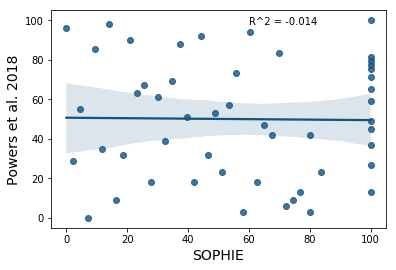

In [36]:
figure_filename = f"pathway_ranking_{col_to_rank_pathways}_MRnorm.svg"

ranking.compare_pathway_ranking(
    summary_pathway_ranks, powers_rank_processed_filename, figure_filename
)

**Takeaway:**

* The above shows that there is no correlation between our ranking (where pathways were ranked using median adjusted p-value score across simulated experiments) vs Powers et. al. ranking (where pathways were ranked based on the fraction of experiments they had adjusted p-value < 0.05). This is using the same workflow used to compare ranking of genes.

* We validated that our analysis pipeline is working correctly by comparing pathway ranks obtained from a (Powers et. al.)-trained VAE model vs pathway ranking based on manual curation using Powers et. al datasets. We expect to see a high correlation between pathway ranks given that we are using the same training dataset. Indeed that is what we find [here](../human_cancer_analysis/2_identify_generic_genes_pathways.ipynb).

**Therefore,**

* We find relatively similar generic genes using our simulation approach (i.e. VAE model trained on a cancer-specific dataset, Powers et. al.) compared to generic genes found from real general experiments from Crow et. al. These generic genes are not that context-specific at the extremes.

* We found very different generic pathways training using our simulation approach trained on a general dataset (recount2) compared to generic pathways found from real cancer-specific experiments from Powers et. al. See [analysis](../human_cancer_analysis/2_identify_generic_genes_pathways.ipynb). But we get very similar generic pathways using our simulation approach trained on a cancer-specific dataset (Powers et. al.) compared with generic pathways found from cancer-specific dataset (Powers et. al.). This indicates that generic pathways are more context specific.

* Why would the context matter more for pathways as opposed to genes? One way to think about this is using this figure from a recent [preprint](https://www.biorxiv.org/content/10.1101/2020.07.30.228296v1).Information flows from a stimulation that activates proteins within pathways and these proteins regulate gene expression. Say we have a context specific signal, that changes the TF within some pathways, this eventually trickles down to changes in gene expression. So if we think about flow of information, measuring pathway activity (or pathway enrichment, etc) will be more sensitive to our context compared to measuring DE in individual genes. Since the genes are regulated as a group, you'd see coordinated changes in expression that are correlated with your condition but looking at the expression of individual genes you wouldn’t necessarily see this correlation with condition.